# examples

In [1]:
import pickle
import numpy as np
np.set_printoptions(linewidth=100)
import pandas as pd

import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import waterPSF, waterDCD
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

# the next line is necessary to display plots in Jupyter
%matplotlib inline

In [2]:
u = mda.Universe(waterPSF, waterDCD)

In [3]:
hbonds = HydrogenBondAnalysis(
    universe=u,
    donors_sel=None,
    hydrogens_sel="name H1 H2",
    acceptors_sel="name OH2",
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=150,
    update_selections=False
)

In [4]:
hbonds.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# We see there are 27 hydrogen bonds in total
print(hbonds.results.hbonds.shape)

(27, 6)


In [6]:
print(hbonds.results.hbonds[0])

[  0.           9.          10.           3.           2.82744082 150.48955173]


In [7]:
hbonds.results.hbonds.dtype

dtype('float64')

In [8]:
first_hbond = hbonds.results.hbonds[0]

In [9]:
frame, donor_ix, hydrogen_ix, acceptor_ix = first_hbond[:4].astype(int)

In [10]:
# select the correct frame and the atoms involved in the hydrogen bond
u.trajectory[frame]
atoms = u.atoms[[donor_ix, hydrogen_ix, acceptor_ix]]

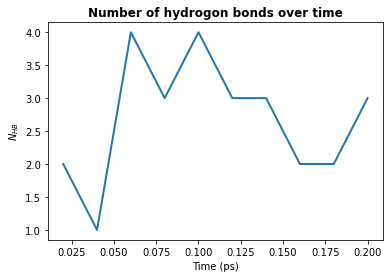

In [11]:
plt.plot(hbonds.times, hbonds.count_by_time(), lw=2)

plt.title("Number of hydrogon bonds over time", weight="bold")
plt.xlabel("Time (ps)")
plt.ylabel(r"$N_{HB}$")

plt.show()

In [13]:
hbonds.count_by_ids()

array([[12, 14,  9, 10],
       [ 9, 10,  3,  9],
       [ 3,  5,  0,  4],
       [ 0,  1,  6,  3],
       [ 6,  7, 12,  1]])

In [14]:
counts = hbonds.count_by_ids()
most_common = counts[0]

print(f"Most common donor: {u.atoms[most_common[0]]}")
print(f"Most common hydrogen: {u.atoms[most_common[1]]}")
print(f"Most common acceptor: {u.atoms[most_common[2]]}")


Most common donor: <Atom 13: OH2 of type OT of resname TIP3, resid 21 and segid WAT>
Most common hydrogen: <Atom 15: H2 of type HT of resname TIP3, resid 21 and segid WAT>
Most common acceptor: <Atom 10: OH2 of type OT of resname TIP3, resid 15 and segid WAT>


In [15]:
# bins in z for the histogram
bin_edges = np.linspace(-25, 25, 51)
bin_centers = bin_edges[:-1] + 0.5

# results array (this is faster and more memory efficient than appending to a list)
counts = np.full(bin_centers.size, fill_value=0.0)

In [16]:
for frame, donor_ix, *_ in hbonds.hbonds:
    
    u.trajectory[frame.astype(int)]
    donor = u.atoms[donor_ix.astype(int)]

    zpos = donor.position[2]
    hist, *_ = np.histogram(zpos, bins=bin_edges)
    counts += hist * 2  # multiply by two as each hydrogen bond involves two water molecules

counts /= hbonds.n_frames

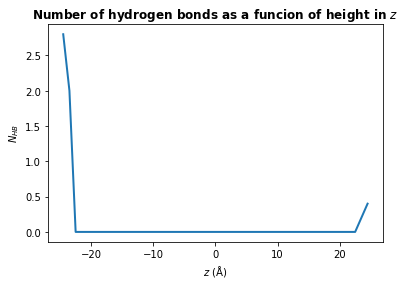

In [17]:
plt.plot(bin_centers, counts, lw=2)

plt.title(r"Number of hydrogen bonds as a funcion of height in $z$", weight="bold")
plt.xlabel(r"$z\ \rm (\AA)$")
plt.ylabel(r"$N_{HB}$")

plt.show()

In [18]:
mean_xy_area = np.mean(
    [np.product(ts.dimensions[:2]) for ts in u.trajectory[hbonds.frames]]
)
counts /= mean_xy_area

# my data

In [31]:
import MDAnalysis as mda
from MDAnalysis import transformations as trans
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

import numpy as np
import matplotlib.pyplot as plt

In [44]:
# dt in ps
u = mda.Universe("./input_data/interface.psf",
                 "./input_data/trajectory.xyz",
                 dt=0.025)
dim = [16.869, 16.869, 41.478, 90, 90, 120]
transform = trans.boxdimensions.set_dimensions(dim)
u.trajectory.add_transformations(transform)

u.transfer_to_memory(step=10)

In [9]:
u_wat = u.select_atoms("resname R1")
print(u_wat)

<AtomGroup [<Atom 1: O of type O of resname R1, resid 1 and segid MOL1>, <Atom 2: H of type H of resname R1, resid 1 and segid MOL1>, <Atom 3: H of type H of resname R1, resid 1 and segid MOL1>, ..., <Atom 688: O of type O of resname R1, resid 230 and segid MOL1>, <Atom 689: H of type H of resname R1, resid 230 and segid MOL1>, <Atom 690: H of type H of resname R1, resid 230 and segid MOL1>]>


In [45]:
hbonds = HydrogenBondAnalysis(
    universe=u,
    donors_sel=None,
    hydrogens_sel="name H",
    acceptors_sel="name O",
    d_a_cutoff=3.0,
    d_h_a_angle_cutoff=150,
    update_selections=False
)

In [46]:
hbonds.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [40]:
print(hbonds.results.hbonds.shape)

(312569, 6)


In [41]:
# [frame, donor_index, hydrogen_index, acceptor_index, DA_distance, DHA_angle]
print(hbonds.results.hbonds[0])

[  0.           0.           1.         255.           2.70921881 166.55259568]


In [25]:
# bins in z for the histogram
bin_edges = np.arange(0, 41.478, 0.1)
bin_centers = bin_edges[:-1] + 0.05

# results array (this is faster and more memory efficient than appending to a list)
counts = np.zeros(bin_centers.size)

In [26]:
for frame, donor_ix, *_ in hbonds.hbonds:
    
    u.trajectory[frame.astype(int)]
    donor = u.atoms[donor_ix.astype(int)]

    zpos = donor.position[2]
    hist, *_ = np.histogram(zpos, bins=bin_edges)
    counts += hist * 2  # multiply by two as each hydrogen bond involves two water molecules

counts /= hbonds.n_frames

/home/jxzhu/.conda/envs/band-alignment/lib/python3.9/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:662: DeprecationWarning: The `hbonds` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.hbonds` instead.
  warnings.warn(wmsg, DeprecationWarning)


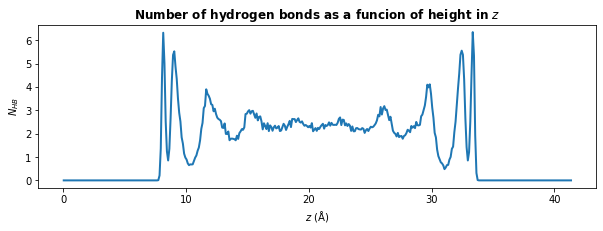

In [28]:
fig = plt.figure(figsize=(10, 3))

plt.plot(bin_centers, counts, lw=2)

plt.title(r"Number of hydrogen bonds as a funcion of height in $z$", weight="bold")
plt.xlabel(r"$z\ \rm (\AA)$")
plt.ylabel(r"$N_{HB}$")

plt.show()


In [47]:
tau_max = 25
window_step = 1
tau_frames, hbond_lifetime = hbonds.lifetime(
    tau_max=tau_max,
    window_step=window_step
)

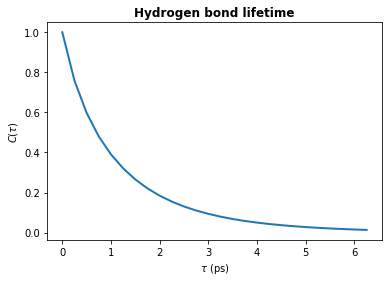

In [48]:
tau_times = tau_frames * u.trajectory.dt
plt.plot(tau_times, hbond_lifetime, lw=2)

plt.title(r"Hydrogen bond lifetime", weight="bold")
plt.xlabel(r"$\tau\ \rm (ps)$")
plt.ylabel(r"$C(\tau)$")

plt.show()

In [49]:
def fit_biexponential(tau_timeseries, ac_timeseries):
    """Fit a biexponential function to a hydrogen bond time autocorrelation function

    Return the two time constants
    """
    from scipy.optimize import curve_fit

    def model(t, A, tau1, B, tau2):
        """Fit data to a biexponential function.
        """
        return A * np.exp(-t / tau1) + B * np.exp(-t / tau2)

    params, params_covariance = curve_fit(model, tau_timeseries, ac_timeseries, [1, 0.5, 1, 2])

    fit_t = np.linspace(tau_timeseries[0], tau_timeseries[-1], 1000)
    fit_ac = model(fit_t, *params)

    return params, fit_t, fit_ac

In [53]:
params, fit_t, fit_ac = fit_biexponential(tau_times, hbond_lifetime)

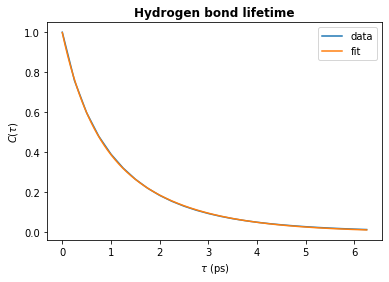

In [54]:
# Plot the fit
plt.plot(tau_times, hbond_lifetime, label="data")
plt.plot(fit_t, fit_ac, label="fit")

plt.title(r"Hydrogen bond lifetime", weight="bold")
plt.xlabel(r"$\tau\ \rm (ps)$")
plt.ylabel(r"$C(\tau)$")

plt.legend()
plt.show()

In [55]:
# Check the decay time constant
A, tau1, B, tau2 = params
time_constant = A * tau1 + B * tau2
print(f"time_constant = {time_constant:.2f} ps")


time_constant = 1.18 ps
